<a href="https://colab.research.google.com/github/leeliangchao/-spatiotemporal-pedict/blob/main/2019%E5%85%A8%E5%B9%B43dto3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [7]:
# !pip install mlxtend==0.18
# from mlxtend.plotting import heatmap


## 范围选择

In [8]:
Longitude_Index = 54    #经度索引
Longitude_End = 62 +1   #经度索引

Latitude_Index = 17  # 纬度索引
Latitude_End = 31 +1 # 纬度索引

In [9]:
Sample = np.load('/content/drive/MyDrive/TEC/日本3台站/CODE/TEC.npy')

In [10]:
Sample.shape

(71, 73, 25, 366, 1)

In [11]:
Target_region = Sample[Latitude_Index:Latitude_End, Longitude_Index:Longitude_End,:,:,:]

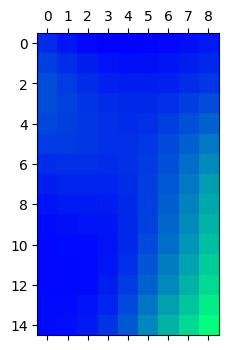

matplotlib.image.AxesImage

In [12]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
line=ax.matshow(Target_region[:,:,-2,0,0], cmap = plt.cm.winter)
plt.show()
type(line)

In [13]:
from matplotlib import animation

In [14]:
def animate(i):
  line.set_data(Target_region[:,:,i,0,0])
  return line,
def init():
  line.set_data(Target_region[:,:,0,0,0])
  return line,
ani = animation.FuncAnimation(fig=fig, func=animate,frames=25,init_func=init,interval=200,blit=False)
ani.save('ani.gif', writer='pillow')
plt.show()

### 样本制作

In [15]:
###################绘图###################
import matplotlib.pyplot as plt
###################标准化###################
from sklearn.preprocessing import MinMaxScaler

In [16]:
Target_region.shape

(15, 9, 25, 366, 1)

In [17]:
data = np.swapaxes(Target_region, 0,2)
data = np.swapaxes(data, 1,3)
data = np.swapaxes(data, 0,1)

In [18]:
data.shape

(366, 25, 15, 9, 1)

In [19]:
data = np.delete(data,[-1], axis=0);data.shape

(365, 25, 15, 9, 1)

In [20]:
data = data.reshape(-1,15,9,1)

In [21]:
data.shape

(9125, 15, 9, 1)

In [22]:
data = data[::2]

In [23]:
data.shape

(4563, 15, 9, 1)

In [24]:
# 数据集划分
def create_dataset(data, look_back=36, forward=36):
  x = []
  y = []
  for i in range(data.shape[0]-(look_back+forward)+1):
    x.append(data[i:i+look_back,:,:,:])
    y.append(data[i+look_back:i+look_back+forward,:,:,:])
  return (np.array(x), np.array(y))


In [25]:
a,b = create_dataset(data)

In [26]:
a.shape,b.shape

((4492, 36, 15, 9, 1), (4492, 36, 15, 9, 1))

In [27]:
# len(df)为df多少行
pot = round(0.8 * a.shape[0])
pot

3594

In [28]:
x_train, y_train = a[:pot],b[:pot]
x_test, y_test = a[pot:],b[pot:]
# y_train = np.expand_dims(y_train, 1)
# y_test = np.expand_dims(y_test, 1)

In [29]:
x_train.shape, x_test.shape,y_test.shape

((3594, 36, 15, 9, 1), (898, 36, 15, 9, 1), (898, 36, 15, 9, 1))

### LearningRateScheduler调整学习率

In [30]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [31]:
def scheduler(epoch):
    if epoch % 40 ==0 :
        lr = K.get_value(tcn.optimizer.lr)
        if lr > 1e-5:
            K.set_value(tcn.optimizer.lr, lr *0.5)
            print('lr changed to {}'.format(lr * 0.5))
    return K.get_value(tcn.optimizer.lr)

In [32]:
reduce_lr = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='loss', 
                               patience=20, 
                               min_delta=1e-5,
                               mode='auto',
                               restore_best_weights=False,#是否从具有监测数量的最佳值的时期恢复模型权重
                               verbose=2)

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D,Conv2D,Conv3D,BatchNormalization
from tensorflow.keras import Input, Model, Sequential
from sklearn.metrics import mean_squared_error

In [34]:
# 自定义损失函数
def my_metric_fn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
# Loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0, filter_size=3))

In [35]:
#输入维数
tcn = Sequential()
input_layer =Input(shape=(x_train.shape[1:]))
tcn.add(input_layer)
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(Conv3D(filters=1, kernel_size=(1, 1,1),activation="relu", padding="same"))
tcn.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss=root_mean_squared_error)# RMSE
tcn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 36, 15, 9, 32)     38144     
                                                                 
 batch_normalization (BatchN  (None, 36, 15, 9, 32)    128       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 36, 15, 9, 32)     32896     
                                                                 
 batch_normalization_1 (Batc  (None, 36, 15, 9, 32)    128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 36, 15, 9, 32)     32896     
                                                                 
 batch_normalization_2 (Batc  (None, 36, 15, 9, 32)    1

In [36]:
# from tensorflow.keras.models import load_model
# tcn = load_model('/content/spatiotemporal_1.h5')
history=tcn.fit(x_train,y_train, 
        epochs=300, batch_size=64, callbacks=[reduce_lr])


lr changed to 0.004999999888241291
Epoch 1/300
57/57 [==============================] - 64s 807ms/step - loss: 6.0638 - lr: 0.0050
Epoch 2/300
57/57 [==============================] - 46s 800ms/step - loss: 2.7091 - lr: 0.0050
Epoch 3/300
57/57 [==============================] - 46s 801ms/step - loss: 2.3176 - lr: 0.0050
Epoch 4/300
57/57 [==============================] - 46s 802ms/step - loss: 2.2123 - lr: 0.0050
Epoch 5/300
57/57 [==============================] - 49s 860ms/step - loss: 2.1263 - lr: 0.0050
Epoch 6/300
57/57 [==============================] - 45s 795ms/step - loss: 2.0581 - lr: 0.0050
Epoch 7/300
57/57 [==============================] - 46s 805ms/step - loss: 2.0449 - lr: 0.0050
Epoch 8/300
57/57 [==============================] - 46s 811ms/step - loss: 2.0186 - lr: 0.0050
Epoch 9/300
57/57 [==============================] - 49s 860ms/step - loss: 1.9623 - lr: 0.0050
Epoch 10/300
57/57 [==============================] - 45s 791ms/step - loss: 1.9244 - lr: 0.0050
Epoc

KeyboardInterrupt: ignored

In [ ]:
# history.history.keys() #查看history中存储了哪些参数

In [ ]:
# plt.plot(history.epoch,history.history.get('my_metric_fn')[:]) #画出随着epoch增大loss的变化图
#plt.plot(history.epoch,history.history.get('acc'))#画出随着epoch增大准确率的变化图

In [ ]:
# plt.plot(history.epoch, history.history.get('lr'))

In [37]:
tcn.evaluate(x_test, y_test)

29/29 [==============================] - 3s 87ms/step - loss: 2.0598


2.0597856044769287

In [38]:
predict = tcn.predict(x_test)

29/29 [==============================] - 3s 86ms/step


In [39]:
predict.shape

(898, 36, 15, 9, 1)

In [40]:
5//4

1

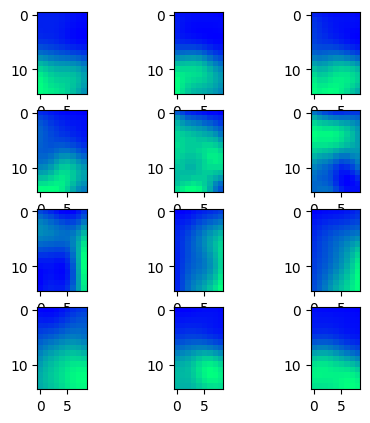

In [41]:
test_day = 100
fig, ax = plt.subplots(4,3,figsize=(5,5),dpi=100)

im1 = ax[0][0].imshow(y_test[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[0][1].imshow(y_test[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[0][2].imshow(y_test[test_day,2,:,:,0], cmap = plt.cm.winter)

im1 = ax[1][0].imshow(y_test[test_day,3,:,:,0], cmap = plt.cm.winter)
im1 = ax[1][1].imshow(y_test[test_day,4,:,:,0], cmap = plt.cm.winter)
im1 = ax[1][2].imshow(y_test[test_day,5,:,:,0], cmap = plt.cm.winter)
im1 = ax[2][0].imshow(y_test[test_day,6,:,:,0], cmap = plt.cm.winter)
im1 = ax[2][1].imshow(y_test[test_day,7,:,:,0], cmap = plt.cm.winter)
im1 = ax[2][2].imshow(y_test[test_day,8,:,:,0], cmap = plt.cm.winter)
im1 = ax[3][0].imshow(y_test[test_day,9,:,:,0], cmap = plt.cm.winter)
im1 = ax[3][1].imshow(y_test[test_day,10,:,:,0], cmap = plt.cm.winter)
im1 = ax[3][2].imshow(y_test[test_day,11,:,:,0], cmap = plt.cm.winter)

# plt.colorbar(im1)

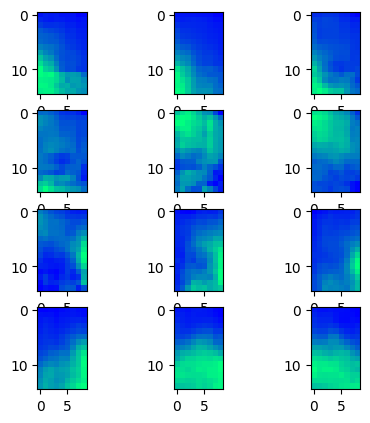

In [42]:
fig, ax = plt.subplots(4,3,figsize=(5,5),dpi=100)

im1 = ax[0][0].imshow(predict[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[0][1].imshow(predict[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[0][2].imshow(predict[test_day,2,:,:,0], cmap = plt.cm.winter)

im1 = ax[1][0].imshow(predict[test_day,3,:,:,0], cmap = plt.cm.winter)
im1 = ax[1][1].imshow(predict[test_day,4,:,:,0], cmap = plt.cm.winter)
im1 = ax[1][2].imshow(predict[test_day,5,:,:,0], cmap = plt.cm.winter)
im1 = ax[2][0].imshow(predict[test_day,6,:,:,0], cmap = plt.cm.winter)
im1 = ax[2][1].imshow(predict[test_day,7,:,:,0], cmap = plt.cm.winter)
im1 = ax[2][2].imshow(predict[test_day,8,:,:,0], cmap = plt.cm.winter)
im1 = ax[3][0].imshow(predict[test_day,9,:,:,0], cmap = plt.cm.winter)
im1 = ax[3][1].imshow(predict[test_day,10,:,:,0], cmap = plt.cm.winter)
im1 = ax[3][2].imshow(predict[test_day,11,:,:,0], cmap = plt.cm.winter)

TypeError: ignored

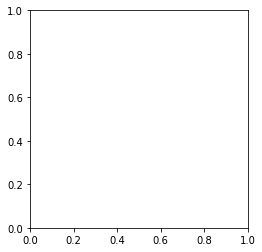

In [43]:
# 预测
plt.imshow(predict[test_day,:,:,0], cmap = plt.cm.winter)
plt.colorbar()

In [59]:
tcn.save('32_BN_300_2.0_2019.h5')

### RMSE计算

In [44]:
from sklearn.metrics import mean_squared_error

In [45]:
P = predict
P = P.reshape(-1,1)
P.shape

(4364280, 1)

In [46]:
R = y_test
R = R.reshape(-1,1)
R.shape

(4364280, 1)

In [47]:
mean_squared_error(R, P, squared=False)

2.113245077248599

### 计算$R^{2}$

In [48]:
from sklearn.metrics import r2_score

In [49]:
r2 = round(r2_score(P, R),4)
r2

0.8856

### 算相对误差直方图

Text(0.5, 0, '相对误差/(TECU)')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23545 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23545 missing from current font.
  font.set_te

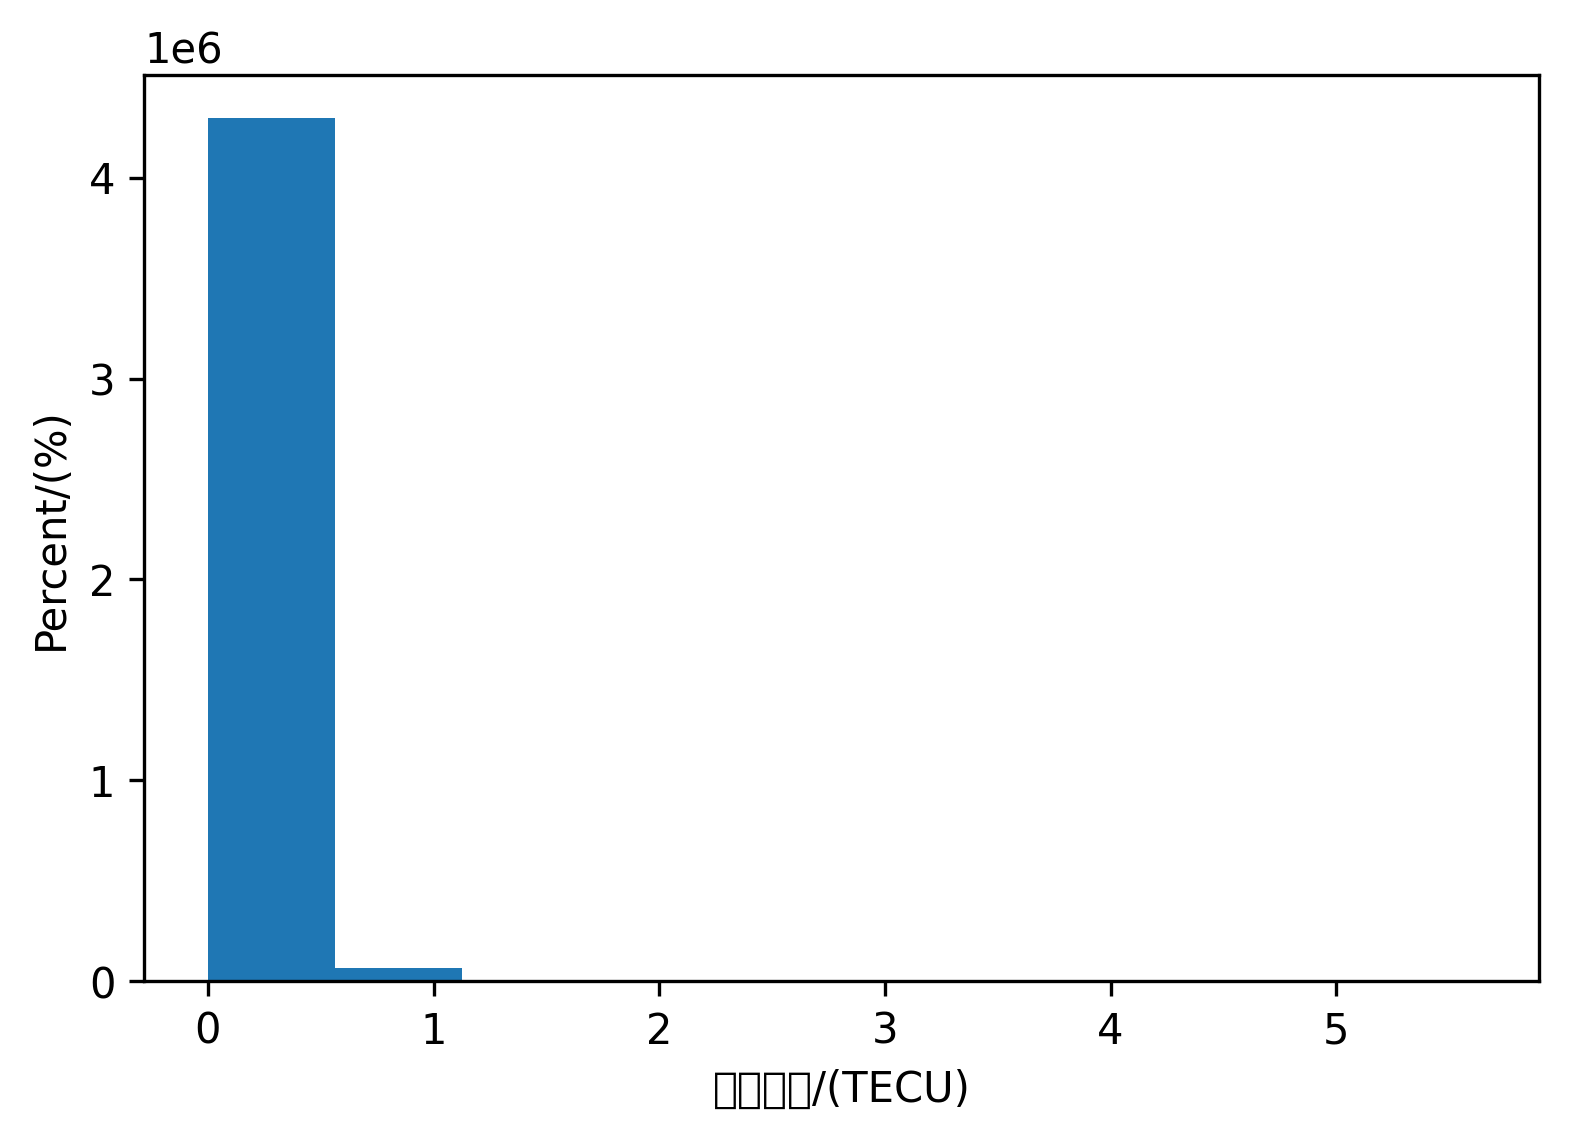

In [58]:
PD = np.abs(R-P)/R
fig, ax = plt.subplots(dpi=300)
ax.hist(PD, density=False)
ax.set_ylabel("Percent/(%)")
ax.set_xlabel("相对误差/(TECU)")

### 计算预测显示的散点图

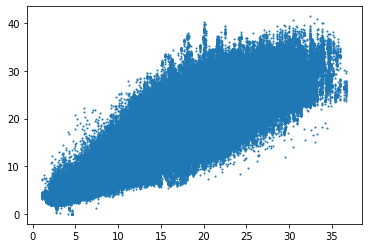

In [56]:
plt.scatter(R,P, s=1)

In [52]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(R, P)

reg.coef_, reg.intercept_

(array([[1.00148783]]), array([0.46763738]))

In [53]:
line_x = np.linspace(0, 70, 2)
y = reg.coef_[0][0] * line_x + reg.intercept_[0]
y

array([ 0.46763738, 70.5717852 ])

In [54]:
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": False,
})

In [55]:
fig = plt.figure(dpi=300) 
plt.scatter(R,P, s=10)
plt.plot(line_x, y, 'k')
# plt.text(100, 40, r'$k_a$', fontsize=18)
plt.xlabel('Observed TEC/TECU', fontsize=18)
plt.ylabel('Forecast TEC/TECU', fontsize=18)
plt.text(50,20, 'R:{}\nK:{}'.format(r2, round(reg.coef_[0][0],4)))

Text(50, 20, 'R:0.8856\nK:1.0015')

Error in callback <function flush_figures at 0x7fe9c9dfc200> (for post_execute):


KeyboardInterrupt: ignored